![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [139]:
rental = pd.read_csv('rental_info.csv')
rental =  rental.drop(columns=['amount_2','length_2','rental_rate_2'])
rental.head(2)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1


In [140]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 1.5+ MB


In [141]:
# Fix columns with time and date
rental['rental_date'] = pd.to_datetime(rental['rental_date']).dt.date
rental['return_date'] = pd.to_datetime(rental['return_date']).dt.date

rental['rental_length_days'] = (
    pd.to_datetime(rental['return_date']) - pd.to_datetime(rental['rental_date'])
).dt.days

# We will consider day 0 as if it were used as a full day.
rental.rental_length_days = rental.rental_length_days.replace(0, 1)
rental.release_year = rental.release_year.astype('int')

rental.head(2)


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,rental_length_days
0,2005-05-25,2005-05-28,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,3
1,2005-06-15,2005-06-18,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,3


In [142]:
rental.rental_length_days.value_counts()

rental_length_days
8     1822
7     1817
6     1777
2     1777
5     1759
1     1741
4     1714
3     1711
9     1615
10     128
Name: count, dtype: int64

In [143]:
rental.special_features.value_counts()

special_features
{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Delete

In [144]:
rental['clean_features'] = (
    rental['special_features']
    .str.replace(r'[\{\}"\']', '', regex=True)  # elimina {}, "" y ''
    .str.split(',')
)

rental['deleted_scenes'] = rental['clean_features'].apply(lambda x: int('Deleted Scenes' in x))
rental['behind_the_scenes'] = rental['clean_features'].apply(lambda x: int('Behind the Scenes' in x))

rental.drop(columns='clean_features', inplace=True)


rental.sample(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,rental_length_days,deleted_scenes,behind_the_scenes
11290,2005-08-01,2005-08-06,3.99,2010,2.99,155.0,25.99,"{Trailers,""Deleted Scenes""}",1,0,0,0,5,1,0
12507,2005-07-13,2005-07-18,1.99,2005,0.99,92.0,21.99,"{Commentaries,""Behind the Scenes""}",1,0,0,0,5,0,1
9250,2005-07-27,2005-07-31,2.99,2007,2.99,176.0,18.99,"{Trailers,""Deleted Scenes""}",0,1,0,0,4,1,0
14301,2005-08-02,2005-08-09,5.99,2008,4.99,182.0,18.99,"{Trailers,Commentaries,""Deleted Scenes"",""Behin...",0,0,0,1,7,1,1
1301,2005-08-19,2005-08-24,2.99,2005,2.99,97.0,12.99,"{Trailers,""Deleted Scenes""}",0,1,0,0,5,1,0


In [145]:
rental = rental.drop(columns=['special_features', 'rental_date', 'return_date'])
rental.head(2)

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,rental_length_days,deleted_scenes,behind_the_scenes
0,2.99,2005,2.99,126.0,16.99,0,0,0,1,3,0,1
1,2.99,2005,2.99,126.0,16.99,0,0,0,1,3,0,1


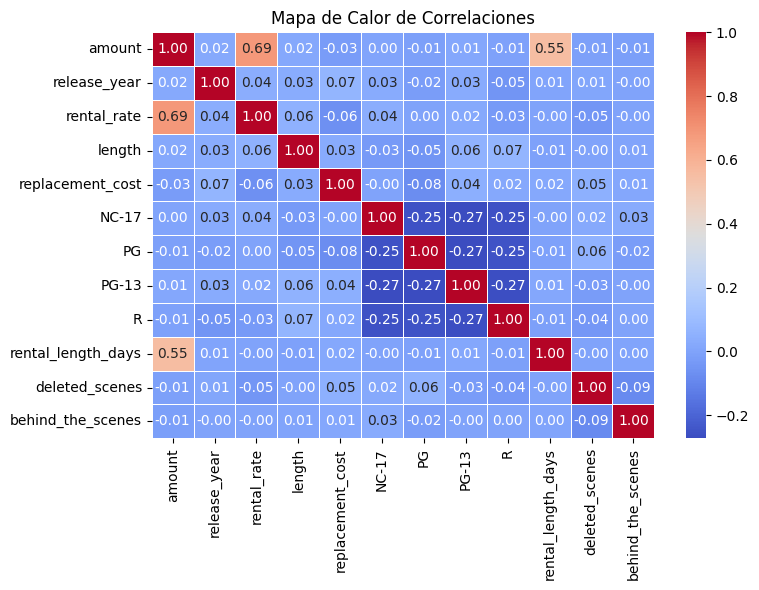

In [146]:

plt.figure(figsize=(8, 6))
sns.heatmap(rental.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor de Correlaciones")
plt.tight_layout()
plt.show()

In [147]:
y = rental['rental_length_days']
X = rental.drop(columns='rental_length_days')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [148]:
three_regressor =  DecisionTreeRegressor(random_state=9)
three_regressor.fit(X_train, y_train)
y_pred = three_regressor.predict(X_test)

In [149]:
mean_squared_error(y_test, y_pred)

2.0125329652679076

In [150]:
X.head(2)

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,deleted_scenes,behind_the_scenes
0,2.99,2005,2.99,126.0,16.99,0,0,0,1,0,1
1,2.99,2005,2.99,126.0,16.99,0,0,0,1,0,1


In [151]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


y = rental['rental_length_days'].values
X = rental.drop(columns='rental_length_days').values

# Normalizar los datos (muy recomendable en regresión)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Dataset personalizado
class RegressionDataset(Dataset):
    def __init__(self, inputs, targets):
        self.X = torch.tensor(inputs, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
import torch.nn as nn

class CustomMLP(nn.Module):
    def __init__(self, input_dim=11, hidden_dims=[64, 128, 64], output_dim=1):
        """
        Args:
            input_dim (int): Dimensión de la capa de entrada
            hidden_dims (list): Lista con las dimensiones de las capas ocultas
            output_dim (int): Dimensión de la capa de salida
        """
        super(CustomMLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        
        # Crear las capas
        layers = []
        
        # Capa de entrada
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        
        # Capas ocultas intermedias
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        # Capa de salida (sin activación para regresión)
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # Convertir la lista de capas en un modelo secuencial
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

Epoch 1/30, Loss train: 5.5969, Loss test: 3.0372
Epoch 2/30, Loss train: 2.8863, Loss test: 2.7740
Epoch 3/30, Loss train: 2.5077, Loss test: 2.4018
Epoch 4/30, Loss train: 2.3137, Loss test: 2.3633
Epoch 5/30, Loss train: 2.2282, Loss test: 2.2581
Epoch 6/30, Loss train: 2.1927, Loss test: 2.4392
Epoch 7/30, Loss train: 2.1564, Loss test: 2.2135
Epoch 8/30, Loss train: 2.0927, Loss test: 2.1810
Epoch 9/30, Loss train: 2.0916, Loss test: 2.3629
Epoch 10/30, Loss train: 2.0570, Loss test: 2.3041
Epoch 11/30, Loss train: 2.0182, Loss test: 2.1188
Epoch 12/30, Loss train: 1.9894, Loss test: 2.1218
Epoch 13/30, Loss train: 1.9755, Loss test: 2.0773
Epoch 14/30, Loss train: 1.9572, Loss test: 2.1291
Epoch 15/30, Loss train: 1.9451, Loss test: 2.0888
Epoch 16/30, Loss train: 1.8943, Loss test: 2.1399
Epoch 17/30, Loss train: 1.9085, Loss test: 2.0304
Epoch 18/30, Loss train: 1.8905, Loss test: 2.1237
Epoch 19/30, Loss train: 1.8737, Loss test: 2.0105
Epoch 20/30, Loss train: 1.8341, Loss te

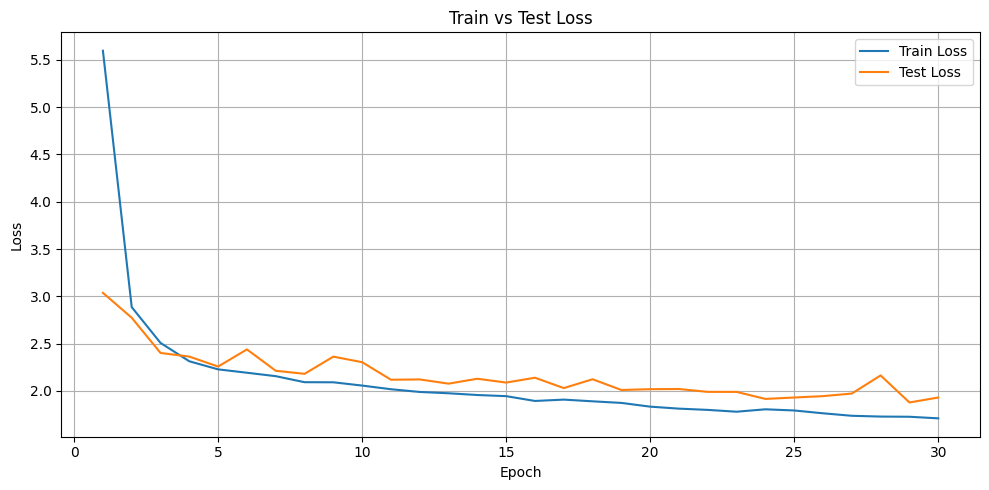

In [160]:
from torch import nn, optim
# Crear instancia con las dimensiones por defecto
model = CustomMLP()

# O crear con dimensiones personalizadas
model = CustomMLP(input_dim=11, hidden_dims=[64,128, 256 , 128, 64], output_dim=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    epoch_test_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            epoch_test_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}/{epochs}, Loss train: {epoch_train_loss:.4f}, Loss test: {epoch_test_loss:.4f}')

# GRAFICAR PÉRDIDAS
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.4.2

Looking in indexes: https://download.pytorch.org/whl/rocm5.4.2
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch

# Detectar GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [1]:
%pip uninstall torch torchvision torchaudio

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.4.2


In [2]:
import requests
# Define new data to create
new_data = {
    "userID": 1,
    "id": 1,
    "title": "Making a POST request",
    "body": "This is the data we created."
}

# The API endpoint to communicate with
url_post = "https://jsonplaceholder.typicode.com/posts"

# A POST request to tthe API
post_response = requests.post(url_post, json=new_data)

# Print the response
post_response_json = post_response.json()
print(post_response_json)

{'userID': 1, 'id': 101, 'title': 'Making a POST request', 'body': 'This is the data we created.'}
